# Word Embedding using Word 2 Vec model to extract similar Locations 

Statistical models are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document.

Word embeddings are better than statistical model in above sence

Considering this feature, we can use word embedding: word2Vec model to our data so as to distinguish between locations which are similar in some context


In [1]:
#Importing dependencies
import pandas as pd 
import numpy as np
from gensim.models import Word2Vec 
import nltk #Natural Language tool kit used for basic dataset cleaning
from sklearn.decomposition import PCA  #Dimensionality reduction 
from sklearn.cluster import AgglomerativeClustering


In [2]:
#Read the data 
df=pd.read_csv('ITES_finalW2Vustry.csv')

In [3]:
#Display top 5 rows 
df.head()

,Unnamed: 0,Unnamed: 0.1,Company_Name,Posted Date,Experience,Salaries,Location,Department,Industry,JD,Skills
0,170,170,phenix data outsourcing hiring for phenixjobs in,nov 04 2020,0 yrs,rs 3.5 9 lakh yr,navi mumbai thane ahmednagar aurangabad pa...,data entry,it software,look best legitimate genuine online offline pa...,work from home work at home passive income dat...
1,282,282,arminus,jan 09 2021,3 to 8 yrs,NaN,bhopal,sales bd,it software,job description qualification pg degree diplom...,food products market management food retail ma...
2,290,290,arminus,jan 09 2021,3 to 6 yrs,NaN,bhopal,it operations edp mis,it software,job description qualification msw master degre...,social anthropology anthropology urban anthrop...
3,297,297,arminus,jan 08 2021,3 to 5 yrs,NaN,bhopal,it operations edp mis,it software,job description qualification degree engineer ...,java automation cramer gc junit entrepreneursh...
4,298,298,arminus,jan 08 2021,3 to 5 yrs,NaN,bhopal,it operations edp mis,it software,job description qualification master degree ec...,data analytics analytics dashboard monitor con...


In [4]:
#Checking for missing values 
df.isnull().sum()

Unnamed: 0          0
Unnamed: 0.1        0
Company_Name        0
Posted Date      1358
Experience          0
Salaries        11222
Location            0
Department          0
Industry            0
JD                  2
Skills              0
dtype: int64

In [5]:
#we wont consider salary and Posted date column as it is have high count of null values

In [6]:
#Getting Dimension of data
df.shape

(12794, 11)

### Prepare a Corpus
Let’s now take a sample corpus of documents on which we will run most of our analyses in this article. A corpus is typically a collection of text documents usually belonging to one or more subjects or domains.
Here we will column 'Location' as the corpus 

In [7]:
#Selecting location column and assign same to corpus
corpus = np.array(df['Location'])

### Prepare Corpus Dataframe
We can consider important column of original dataset which we want to see in the output as Corpus Dataframe
We will consider 'Company_Name','Industry','Department','Location','Skills' as the essentials for corpus dataframe

In [8]:
corpus_df = df[['Company_Name','Industry','Department','Location','Skills']]
corpus_df.head()

,Company_Name,Industry,Department,Location,Skills
0,phenix data outsourcing hiring for phenixjobs in,it software,data entry,navi mumbai thane ahmednagar aurangabad pa...,work from home work at home passive income dat...
1,arminus,it software,sales bd,bhopal,food products market management food retail ma...
2,arminus,it software,it operations edp mis,bhopal,social anthropology anthropology urban anthrop...
3,arminus,it software,it operations edp mis,bhopal,java automation cramer gc junit entrepreneursh...
4,arminus,it software,it operations edp mis,bhopal,data analytics analytics dashboard monitor con...


## Simple Text Pre-processing
We will build a simple text pre-processor which focuses on removing special characters, extra whitespaces, digits, stopwords and lower casing the text corpus.

In [9]:
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malvikakarn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malvikakarn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array(['navi mumbai thane ahmednagar aurangabad palghar raigad bhopal dombivali coimbatore vasai',
       'bhopal', 'bhopal', ..., 'durgapur', 'durgapur', 'durgapur'],
      dtype='<U206')

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


# Word2Vec Model


Word2Vec is a group of models which helps derive relations between a word and its contextual words. 
2 important models inside Word2Vec: 
Skip-grams and CBOW
For ours we will use Skip-gram model
In skip gram we take a centre word and a window of context (neighbour) words and we try to predict context words out to some window size for each centre word. So, our model is going to define a probability distribution
 i.e. probability of a word appearing in context given a centre word and we are going to choose our vector representations to maximize the probability.


The gensim framework, consists of a robust, efficient and scalable implementation of the Word2Vec model. We will leverage the same on our corpus. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it


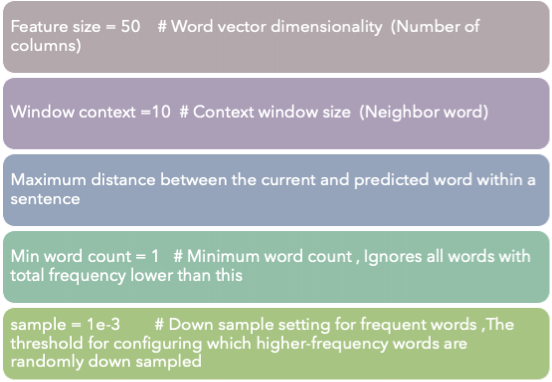

In [11]:
import nltk
from gensim.models import word2vec

tokenized_corpus = [nltk.word_tokenize(doc) for doc in norm_corpus]

# Set values for various parameters
feature_size = 50    # Word vector dimensionality  
window_context =10  # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sg=sg, sample=sample)
w2v_model



# Visualize Location Embeddings
In order to visualize the word embeddings, we need to reduce dimensionality of matrix obtained (using genism library) by W2V model following operations have to be done:

Use dimensionality reduction technique

For this we are using TSNE from Sklearn’s manifold 

TSNE is the powerful library which is helpful in visualize dataset easily


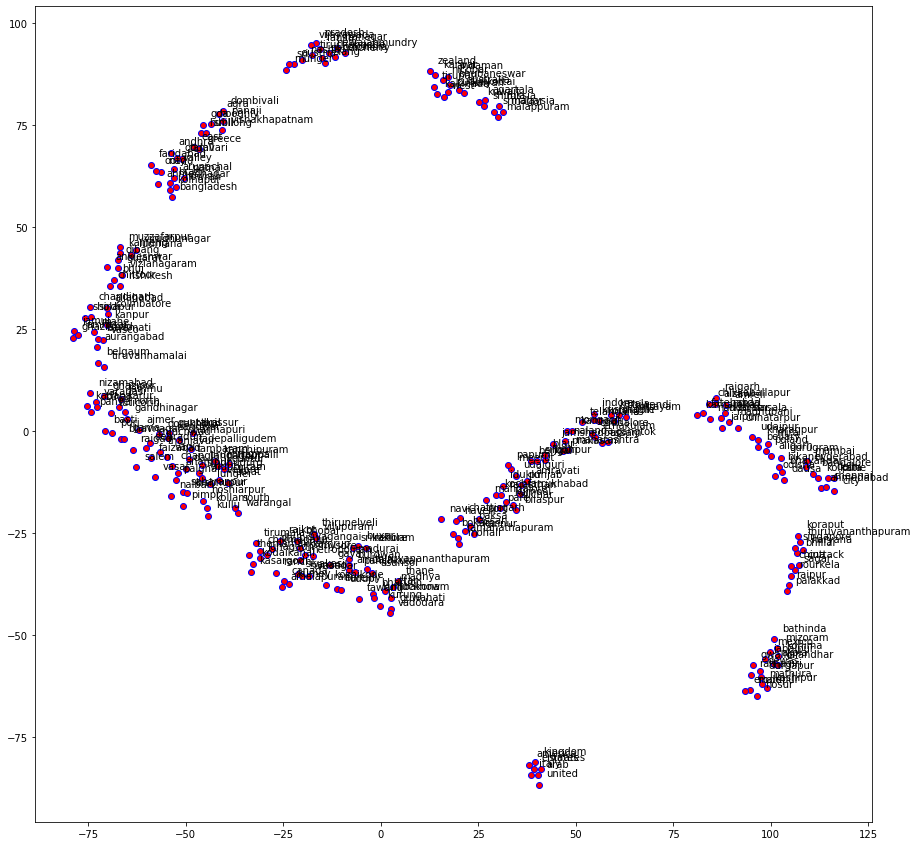

In [12]:
import matplotlib.pyplot as plt

vectors = np.asarray(w2v_model.wv.vectors)
%matplotlib inline

# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=6)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

   
plt.figure(figsize=(15, 15))
plt.scatter(T[:, 0], T[:, 1], c='red', edgecolors='b')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+2, y+2), xytext=(0, 0), textcoords='offset points')

In [13]:
w2v_model.wv['mumbai'], w2v_model.wv['mumbai'].shape

(array([ 0.20026897, -0.00074912,  0.08666189,  0.00726207, -0.00515081,
        -0.11049002,  0.08349886,  0.03399524,  0.00655091,  0.08863769,
        -0.03024987, -0.01367718,  0.01456484, -0.07989497,  0.0896652 ,
        -0.01433058,  0.00042336,  0.07983966,  0.01987601, -0.03670079,
        -0.08279845,  0.05579714,  0.01926557,  0.05191983, -0.04168052,
         0.03051238,  0.079772  ,  0.05756897, -0.03524995, -0.01738006,
        -0.06982831, -0.08068129,  0.00556072,  0.06031241, -0.02731069,
         0.02516461, -0.04384131, -0.08115998, -0.0447168 , -0.06917508,
         0.02664145, -0.02972475, -0.07195055, -0.06916182, -0.14080685,
         0.0779018 ,  0.08830493,  0.03682718, -0.0415311 , -0.01423963],
       dtype=float32),
 (50,))

## It's Becoming Hard to Read
With a dataset this large, its difficult to make an easy-to-read TSNE visualization. What we can do is use the model to look up the most similar words from any given point.

# Find similar Locations:

Using model.most_similar() function


In [14]:
#1.using model.most_similar() function to find most similar words with given any input word
w2v_model.most_similar('bangalore')

<ipython-input-14-c34f0e834a34>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar('bangalore')


[('kolkata', 0.9879733324050903),
 ('ooty', 0.9879515767097473),
 ('metropolitan', 0.9876664876937866),
 ('nilgiris', 0.9874671101570129),
 ('hyderabad', 0.9874513745307922),
 ('kumbakonam', 0.9873970150947571),
 ('amreli', 0.9872841835021973),
 ('nadu', 0.9872071743011475),
 ('viluppuram', 0.9870623350143433),
 ('jamui', 0.9868938326835632)]

In [15]:
#Creating vector dataframe so that we can have a better representations of each word's vector
vec_df = pd.DataFrame(wvs, index=words)
vec_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
bangalore,0.171565,0.012177,0.076670,0.025749,-0.004018,-0.114089,0.085959,0.016182,0.014494,0.076840,...,0.007978,-0.029368,-0.060554,-0.053208,-0.113666,0.051636,0.103029,0.040472,-0.039067,-0.014381
mumbai,0.200269,-0.000749,0.086662,0.007262,-0.005151,-0.110490,0.083499,0.033995,0.006551,0.088638,...,0.026641,-0.029725,-0.071951,-0.069162,-0.140807,0.077902,0.088305,0.036827,-0.041531,-0.014240
city,0.140653,0.035268,0.080645,0.032010,0.007239,-0.098258,0.055466,0.039615,0.033687,0.061539,...,0.022833,-0.036416,-0.076563,-0.079003,-0.082922,0.056132,0.112834,0.033045,-0.022532,-0.005879
kolkata,0.160153,0.015662,0.077431,0.016471,0.002938,-0.106165,0.074089,0.022609,0.023316,0.078171,...,0.022401,-0.029506,-0.063510,-0.056753,-0.117230,0.065749,0.084932,0.025265,-0.025178,-0.012221
ahmedabad,0.143284,0.022795,0.068106,0.027586,0.010852,-0.093332,0.066223,0.027050,0.004821,0.049635,...,0.016737,-0.023087,-0.060741,-0.054855,-0.098294,0.059154,0.087159,0.040072,-0.031923,-0.010352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mathura,0.002754,0.005933,-0.004776,0.009829,0.004725,0.007200,0.004667,-0.009317,-0.008757,0.006304,...,-0.004781,-0.009383,-0.006589,0.009845,0.006775,-0.002737,-0.007510,0.003309,0.001086,0.001502
siliguri,0.295409,0.001232,0.104608,0.034880,0.002621,-0.170467,0.146313,0.038439,0.017998,0.135414,...,0.040564,-0.050147,-0.099432,-0.092330,-0.161942,0.093012,0.178821,0.089821,-0.105726,-0.048747
farrukhabad,0.298696,-0.012725,0.111957,0.040821,0.015633,-0.174690,0.153321,0.028433,0.011990,0.138150,...,0.038974,-0.053634,-0.098776,-0.086587,-0.180763,0.084698,0.190029,0.098272,-0.105447,-0.050577
kannauj,0.277281,-0.012476,0.094227,0.040055,0.012392,-0.144567,0.141197,0.030212,0.017270,0.120987,...,0.043756,-0.058847,-0.091337,-0.073074,-0.153565,0.082821,0.177598,0.085141,-0.088866,-0.045991


# Looking at term semantic similarity


In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df

,bangalore,mumbai,city,kolkata,ahmedabad,chennai,hyderabad,delhi,pune,indore,...,dausa,bengal,telangana,krishnagiri,aligarh,mathura,siliguri,farrukhabad,kannauj,kashipur
bangalore,1.000000,0.983682,0.961317,0.987973,0.986767,0.980757,0.987452,0.984841,0.979539,0.981043,...,0.976852,0.985231,0.980650,0.984404,0.982011,-0.109497,0.982565,0.983824,0.982388,-0.060875
mumbai,0.983682,1.000000,0.934855,0.984162,0.976977,0.964425,0.983826,0.969019,0.964672,0.970895,...,0.966633,0.973363,0.968038,0.973482,0.972699,-0.100157,0.973865,0.973634,0.971159,-0.071923
city,0.961317,0.934855,1.000000,0.959998,0.968801,0.970905,0.957891,0.962953,0.967438,0.941538,...,0.942514,0.942684,0.947925,0.949848,0.943760,-0.168965,0.941836,0.944088,0.948791,-0.117217
kolkata,0.987973,0.984162,0.959998,1.000000,0.983180,0.980704,0.984789,0.980527,0.973121,0.968770,...,0.965514,0.973338,0.967791,0.973083,0.972448,-0.118349,0.971491,0.970454,0.970581,-0.101905
ahmedabad,0.986767,0.976977,0.968801,0.983180,1.000000,0.983296,0.989363,0.977721,0.969363,0.973630,...,0.973576,0.976560,0.973881,0.975889,0.973028,-0.114963,0.974525,0.976590,0.975992,-0.073851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mathura,-0.109497,-0.100157,-0.168965,-0.118349,-0.114963,-0.140436,-0.066944,-0.091190,-0.083244,-0.078472,...,-0.100553,-0.076646,-0.069557,-0.089206,-0.083325,1.000000,-0.080922,-0.092385,-0.067951,0.313266
siliguri,0.982565,0.973865,0.941836,0.971491,0.974525,0.972227,0.981339,0.969010,0.966871,0.996123,...,0.992369,0.997068,0.995526,0.996249,0.994683,-0.080922,1.000000,0.996343,0.996408,-0.063419
farrukhabad,0.983824,0.973634,0.944088,0.970454,0.976590,0.971631,0.979798,0.972910,0.969169,0.996090,...,0.991530,0.995949,0.995683,0.996365,0.994934,-0.092385,0.996343,1.000000,0.996655,-0.058376
kannauj,0.982388,0.971159,0.948791,0.970581,0.975992,0.972663,0.981444,0.973490,0.972069,0.995054,...,0.992859,0.995154,0.996484,0.996653,0.994933,-0.067951,0.996408,0.996655,1.000000,-0.049485


In [17]:
feature_names = np.array(words)
SimilarLoc=similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:5]], 
                    axis=1)

In [18]:
SimilarLoc

bangalore        [kolkata, ooty, metropolitan, nilgiris]
mumbai         [kolkata, hyderabad, bangalore, nilgiris]
city                   [chennai, ahmedabad, pune, delhi]
kolkata        [bangalore, hyderabad, mumbai, ahmedabad]
ahmedabad       [hyderabad, bangalore, chennai, kolkata]
                                 ...                    
mathura             [kashipur, durgapur, hosur, manipur]
siliguri                 [states, siang, arab, kakinada]
farrukhabad     [tiruchengode, howrah, malaysia, russia]
kannauj             [sri, pudukkottai, emirates, kalyan]
kashipur           [mathura, hosur, jalandhar, durgapur]
Length: 294, dtype: object

In [19]:
#Finding similar locations using loc method
similar_location_set  = SimilarLoc.loc["bangalore"]
similar_location_set

array(['kolkata', 'ooty', 'metropolitan', 'nilgiris'], dtype='<U20')

# Getting document level embeddings


In [20]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [21]:
# get document level embeddings
w2v_doc_features = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
feature=pd.DataFrame(w2v_doc_features)